# Heads-Up

In this notebook, we investigate the effect of making the model more informed,
i.e., the model is allowed to look many steps ahead.

However, some constraints will be put on the selected second, third... neighbors.
For instance, only the closest two or three (to be made flexible) neighbors will
be selected. The closeness is based on both cos-distance and geo-distance.

# Some numbers

The length of each sample is:  

max_degree * (w ^ d - 1) + 4  

w is the search width at each step and d is the search depth.
A reasonable maximum search depth when w = 2 is around 13.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import mxnet as mx
import logging
from sklearn.metrics import accuracy_score
from utils import plot_g

In [2]:
NUM_NODE = 100
WEIGHT_MIN = .5
WEIGHT_MAX = 1.

In [3]:
def calc_euclidean_dist(G, tmp_node, node):
    
    p_1 = np.array([G.nodes[tmp_node]['x'], G.nodes[tmp_node]['y']])
    p_2 = np.array([G.nodes[node]['x'], G.nodes[node]['y']])
    return np.sqrt(np.sum((p_1 - p_2)**2))

def generate_low_degree_g(node_size=100, min_out_degree=2, max_out_degree=4, weight_min=WEIGHT_MIN, weight_max=WEIGHT_MAX):
    
    G = nx.Graph()
    
    grid_size = 1000
    euclidean_coords = np.linspace(0.01, 1.0, num=grid_size, endpoint=False)
    coords_indices = list(range(grid_size))
    
    random.shuffle(coords_indices)
    x_coords = euclidean_coords[coords_indices][:node_size]
#     print(x_coords)
    random.shuffle(coords_indices)
    y_coords = euclidean_coords[coords_indices][:node_size]
#     print(y_coords)
    
    # Add coordinates to nodes
    for node, coord in enumerate(zip(x_coords, y_coords)):
#         print(node, coord[0], coord[1])
        G.add_node(node, x=coord[0], y=coord[1])
    
    for node in G.nodes:
        
        tmp_nodes = list(G.nodes)
        tmp_nodes.remove(node)
        node_dist = map(lambda tmp_node: (tmp_node, calc_euclidean_dist(G, tmp_node, node)), tmp_nodes)
        node_dist = sorted(node_dist, key=lambda d:d[1])
        
        num_of_neighbors = random.randint(min_out_degree, max_out_degree)
#         print(node, out_neighbors)
        
#         G.add_edges_from(map(lambda d:(node, d), out_neighbors))
        
        for tmp_node in node_dist:

            if G.degree(tmp_node[0]) >= max_out_degree \
                or G.degree(node) >= num_of_neighbors:
                # This node has maximum number of neighbors already
                continue
            
            weight = random.uniform(weight_min, weight_max)
            geo_dist = calc_euclidean_dist(G, tmp_node[0], node)
            
            G.add_edge(node, tmp_node[0], weight=weight * geo_dist)
    
    # Add centrality to edges
    edge_centrality = nx.edge_betweenness_centrality(G, \
                                                     k=G.number_of_nodes(), \
                                                     weight='weight')
    assert len(edge_centrality) == G.number_of_edges()
    
    for edge_data in G.edges.data():
        edge_data[2]['centrality'] = edge_centrality[(edge_data[0], edge_data[1])]
        
    return G

4
2
20
35


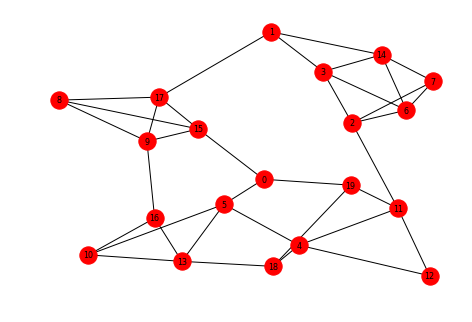

In [9]:
G = generate_low_degree_g(node_size=20)
max_degree = max(G.degree, key=lambda d: d[1])[1]
min_degree = min(G.degree, key=lambda d: d[1])[1]
print(max_degree)
print(min_degree)
print(G.number_of_nodes())
print(G.number_of_edges())
plot_g(G)

In [10]:
def traverse_g_helper(G, parent_node, cur_node, step, depth):
    
    if step > depth:
        return
        
    for edge in G.edges(cur_node):
        
        neighbor = edge[1]
        if neighbor == parent_node:
            continue
        
        print('Step %d: from %d to %d' % (step, cur_node, neighbor))
        traverse_g_helper(G, cur_node, neighbor, step+1, depth)
    
def traverse_g(G, src, parent_node=-1, depth=3):
    
    traverse_g_helper(G, parent_node, src, 1, depth)

In [54]:
def calc_dot_dist(p1, p2):
    return np.dot(p1, p2)

def calc_geo_dist(p1, p2):

    p_1 = np.array(p1)
    p_2 = np.array(p2)

    return np.sqrt(np.sum((p_1 - p_2)**2))

def heuristic(node, dst):

    x_src = G.nodes[src]['x']
    y_src = G.nodes[src]['y']
    x_dst = G.nodes[dst]['x']
    y_dst = G.nodes[dst]['y']
    x_node = G.nodes[node]['x']
    y_node = G.nodes[node]['y']

    dist_src_2_dst = calc_geo_dist((x_src, y_src), (x_dst, y_dst))
    dot_src_2_node = calc_dot_dist((x_node-x_src, y_node-y_src), (x_dst-x_src, y_dst-y_src))
    ret = dist_src_2_dst - (dot_src_2_node) / dist_src_2_dst

    return ret

def extract_path(prev, src, dst):
    
    path = []
    u = dst

    while prev[u] != src:
        path.insert(0, u)
        u = prev[u]
        
        if len(path) >= G.number_of_nodes():
            break
    
    path.insert(0, u)
    path.insert(0, src)
    return path

def bfs_beam_edges_path(G, src, dst):
    
    closeness = dict()
    
    for node in G.nodes():
        if node == src:
            continue

        closeness[node] = -heuristic(node, dst)
    
    prev = [-1 for _ in range(G.number_of_nodes())]
    
    for u, v in nx.bfs_beam_edges(G, src, value=closeness.get, width=2):
        prev[v] = u

    return extract_path(prev, src, dst)

In [55]:
src, dst = 7, 18

print(bfs_beam_edges_path(G, src, dst))
print(nx.dijkstra_path(G, src, dst))
print(nx.astar_path(G, src, dst, heuristic=heuristic))

[7, 2, 11, 4, 18]
[7, 2, 11, 4, 18]
[7, 2, 11, 4, 18]


In [56]:
for src in G.nodes():
    for dst in G.nodes():
        
        if src == dst:
            continue
        
        print('a star path:', nx.astar_path(G, src, dst, heuristic=heuristic))
        print('dijkstra path:', nx.dijkstra_path(G, src, dst, weight='weight'))
        print('beam search path:', bfs_beam_edges_path(G, src, dst))
        print('')

('a star path:', [0, 15, 17, 1])
('dijkstra path:', [0, 15, 17, 1])
('beam search path:', [0, 15, 17, 1])

('a star path:', [0, 19, 11, 2])
('dijkstra path:', [0, 19, 11, 2])
('beam search path:', [0, 19, 11, 2])

('a star path:', [0, 19, 11, 2, 3])
('dijkstra path:', [0, 19, 11, 2, 3])
('beam search path:', [0, 15, 17, 1, 3])

('a star path:', [0, 5, 4])
('dijkstra path:', [0, 5, 4])
('beam search path:', [0, 5, 4])

('a star path:', [0, 5])
('dijkstra path:', [0, 5])
('beam search path:', [0, 5])

('a star path:', [0, 19, 11, 2, 6])
('dijkstra path:', [0, 19, 11, 2, 6])
('beam search path:', [0, 19, 11, 2, 6])

('a star path:', [0, 19, 11, 2, 7])
('dijkstra path:', [0, 19, 11, 2, 7])
('beam search path:', [0, 19, 11, 2, 7])

('a star path:', [0, 15, 8])
('dijkstra path:', [0, 15, 8])
('beam search path:', [0, 15, 8])

('a star path:', [0, 15, 9])
('dijkstra path:', [0, 15, 9])
('beam search path:', [0, 15, 8, 9])

('a star path:', [0, 5, 10])
('dijkstra path:', [0, 5, 10])
('beam sea

('beam search path:', [6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0])

('a star path:', [6, 3, 1])
('dijkstra path:', [6, 3, 1])
('beam search path:', [6, 3, 1])

('a star path:', [6, 2])
('dijkstra path:', [6, 2])
('beam search path:', [6, 2])

('a star path:', [6, 3])
('dijkstra path:', [6, 3])
('beam search path:', [6, 3])

('a star path:', [6, 2, 11, 4])
('dijkstra path:', [6, 2, 11, 4])
('beam search path:', [6, 2, 11, 4])

('a star path:', [6, 2, 11, 4, 5])
('dijkstra path:', [6, 2, 11, 19, 0, 5])
('beam search path:', [6, 2, 11, 4, 5])

('a star path:', [6, 7])
('dijkstra path:', [6, 7])
('beam search path:', [6, 7])

('a star path:', [6, 3, 1, 17, 8])
('dijkstra path:', [6, 3, 1, 17, 8])
('beam search path:', [6, 3, 1, 17, 8])

('a star path:', [6, 3, 1, 17, 9])
('dijkstra path:', [6, 3, 1, 17, 9])
('beam search path:', [6, 3, 1, 17, 9])

('a star path:', [6, 2, 11, 4, 18, 13, 10])
('dijkstra path:', [6, 2, 11, 4, 18, 13, 10])
('beam sear

('dijkstra path:', [10, 13, 18, 4, 11, 2])
('beam search path:', [10, 5, 4, 11, 2])

('a star path:', [10, 16, 9, 17, 1, 3])
('dijkstra path:', [10, 16, 9, 17, 1, 3])
('beam search path:', [10, 16, 9, 17, 1, 3])

('a star path:', [10, 13, 18, 4])
('dijkstra path:', [10, 13, 18, 4])
('beam search path:', [10, 5, 4])

('a star path:', [10, 5])
('dijkstra path:', [10, 5])
('beam search path:', [10, 5])

('a star path:', [10, 16, 9, 17, 1, 3, 6])
('dijkstra path:', [10, 13, 18, 4, 11, 2, 6])
('beam search path:', [10, 5, 4, 11, 2, 6])

('a star path:', [10, 16, 9, 17, 1, 14, 7])
('dijkstra path:', [10, 13, 18, 4, 11, 2, 7])
('beam search path:', [10, 5, 4, 11, 2, 7])

('a star path:', [10, 16, 9, 8])
('dijkstra path:', [10, 16, 9, 8])
('beam search path:', [10, 16, 9, 8])

('a star path:', [10, 16, 9])
('dijkstra path:', [10, 16, 9])
('beam search path:', [10, 16, 9])

('a star path:', [10, 5, 0, 19, 11])
('dijkstra path:', [10, 13, 18, 4, 11])
('beam search path:', [10, 5, 4, 11])

('a st

('beam search path:', [18, 19, 11, 2])

('a star path:', [18, 4, 11, 2, 3])
('dijkstra path:', [18, 4, 11, 2, 3])
('beam search path:', [18, 19, 11, 2, 3])

('a star path:', [18, 4])
('dijkstra path:', [18, 4])
('beam search path:', [18, 4])

('a star path:', [18, 4, 5])
('dijkstra path:', [18, 4, 5])
('beam search path:', [18, 13, 5])

('a star path:', [18, 4, 11, 2, 6])
('dijkstra path:', [18, 4, 11, 2, 6])
('beam search path:', [18, 19, 11, 2, 7, 6])

('a star path:', [18, 4, 11, 2, 7])
('dijkstra path:', [18, 4, 11, 2, 7])
('beam search path:', [18, 19, 11, 2, 7])

('a star path:', [18, 13, 16, 9, 8])
('dijkstra path:', [18, 13, 16, 9, 8])
('beam search path:', [18, 13, 16, 9, 8])

('a star path:', [18, 13, 16, 9])
('dijkstra path:', [18, 13, 16, 9])
('beam search path:', [18, 13, 16, 9])

('a star path:', [18, 13, 10])
('dijkstra path:', [18, 13, 10])
('beam search path:', [18, 13, 10])

('a star path:', [18, 4, 11])
('dijkstra path:', [18, 4, 11])
('beam search path:', [18, 19, 1